In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, Imputer 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report

# Load Dataset

In [2]:
email = pd.read_csv('email_data/email_table.csv')
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [3]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
dtypes: int64(3), object(4)
memory usage: 3.8+ MB


In [4]:
email.isnull().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
dtype: int64

In [5]:
email_opened = pd.read_csv('email_data/email_opened_table.csv')
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [6]:
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
email_id    10345 non-null int64
dtypes: int64(1)
memory usage: 80.9 KB


In [7]:
link = pd.read_csv('email_data/link_clicked_table.csv')
link.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [8]:
link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
email_id    2119 non-null int64
dtypes: int64(1)
memory usage: 16.6 KB


In [9]:
print('email.csv: \t', len(email['email_id'].unique()))
print('email_opened.csv: \t', len(email_opened['email_id'].unique()))
print('link_clicked.csv: \t', len(link['email_id'].unique()))

email.csv: 	 100000
email_opened.csv: 	 10345
link_clicked.csv: 	 2119


In [10]:
#combine tables as new dataset
email_opened['opened'] = 1
link['clicked'] = 1
data = pd.merge(left = email, right = email_opened, how = 'left', on = 'email_id')
data = pd.merge(left = data, right = link, how = 'left', on = 'email_id')
data = data.fillna(0)
data['opened'] = data['opened'].astype(int)
data['clicked'] = data['clicked'].astype(int)
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
email_id               100000 non-null int64
email_text             100000 non-null object
email_version          100000 non-null object
hour                   100000 non-null int64
weekday                100000 non-null object
user_country           100000 non-null object
user_past_purchases    100000 non-null int64
opened                 100000 non-null int32
clicked                100000 non-null int32
dtypes: int32(2), int64(3), object(4)
memory usage: 5.3+ MB


In [12]:
data.describe()

,email_id,hour,user_past_purchases,opened,clicked
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,498690.196160,9.059300,3.87845,0.103450,0.021190
std,289230.727534,4.439637,3.19611,0.304547,0.144018
min,8.000000,1.000000,0.00000,0.000000,0.000000
25%,246708.250000,6.000000,1.00000,0.000000,0.000000
50%,498447.000000,9.000000,3.00000,0.000000,0.000000
75%,749942.750000,12.000000,6.00000,0.000000,0.000000
max,999998.000000,24.000000,22.00000,1.000000,1.000000


# Q1: % of Opened, % of Clicked

In [13]:
print('{0:25s} {1:>8.4f}%'.format('Opened Percentage:', data['opened'].mean()*100))
print('{0:25s} {1:>8.4f}%'.format('Clicked Percentage:', data['clicked'].mean()*100))

Opened Percentage:         10.3450%
Clicked Percentage:         2.1190%


# Q2: Model to optimize probability of click

In [14]:
data.groupby('clicked')['email_id'].count()/len(data)

clicked
0    0.97881
1    0.02119
Name: email_id, dtype: float64

## Click Analysis

### Email Text

In [15]:
data['email_text'].unique()

array(['short_email', 'long_email'], dtype=object)

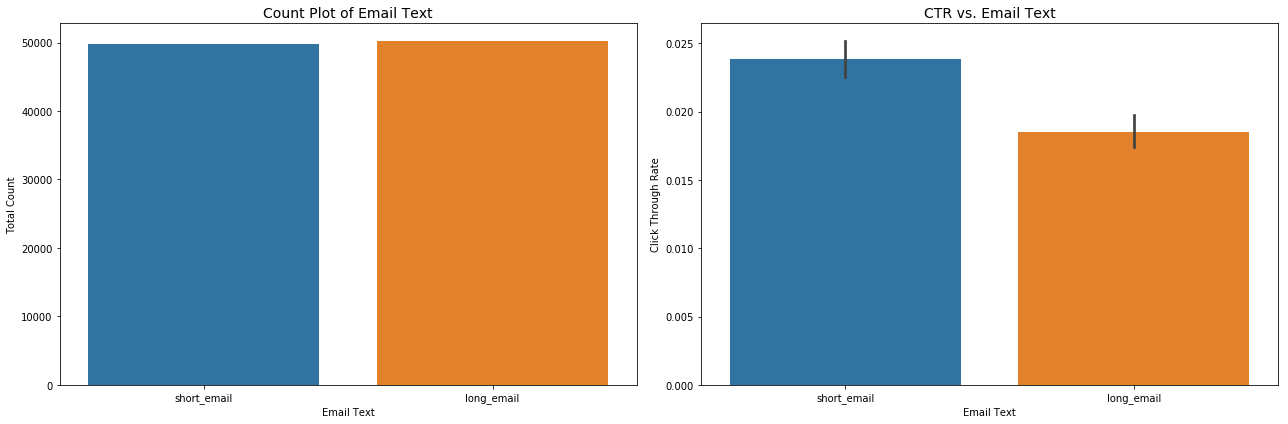

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'email_text', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Email Text', fontsize = 14)
ax[0].set_xlabel('Email Text', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'email_text', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. Email Text', fontsize = 14)
ax[1].set_xlabel('Email Text', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

### Email Version

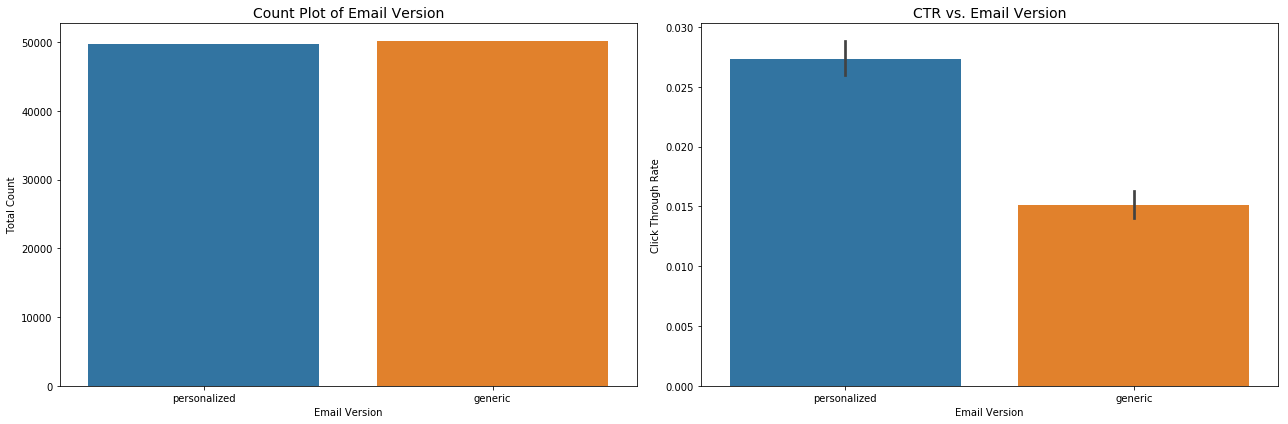

In [17]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'email_version', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Email Version', fontsize = 14)
ax[0].set_xlabel('Email Version', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'email_version', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. Email Version', fontsize = 14)
ax[1].set_xlabel('Email Version', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

### Hour

In [18]:
data['hour'].unique()

array([ 2, 12, 11,  6, 14,  9,  8,  5, 23,  7, 10,  3,  4,  1, 13, 15, 17,
       16, 20, 18, 19, 22, 21, 24], dtype=int64)

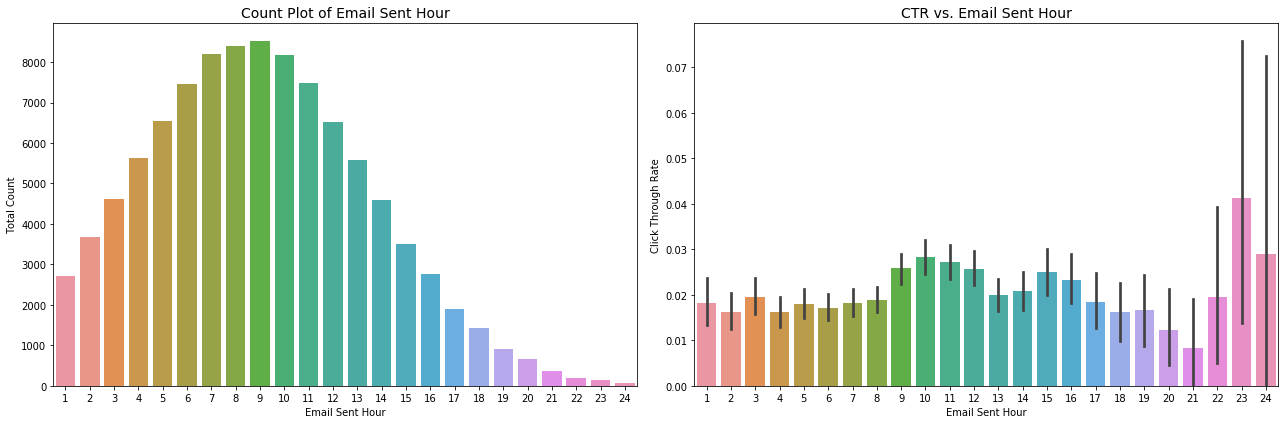

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'hour', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Email Sent Hour', fontsize = 14)
ax[0].set_xlabel('Email Sent Hour', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'hour', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. Email Sent Hour', fontsize = 14)
ax[1].set_xlabel('Email Sent Hour', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

### Weekday

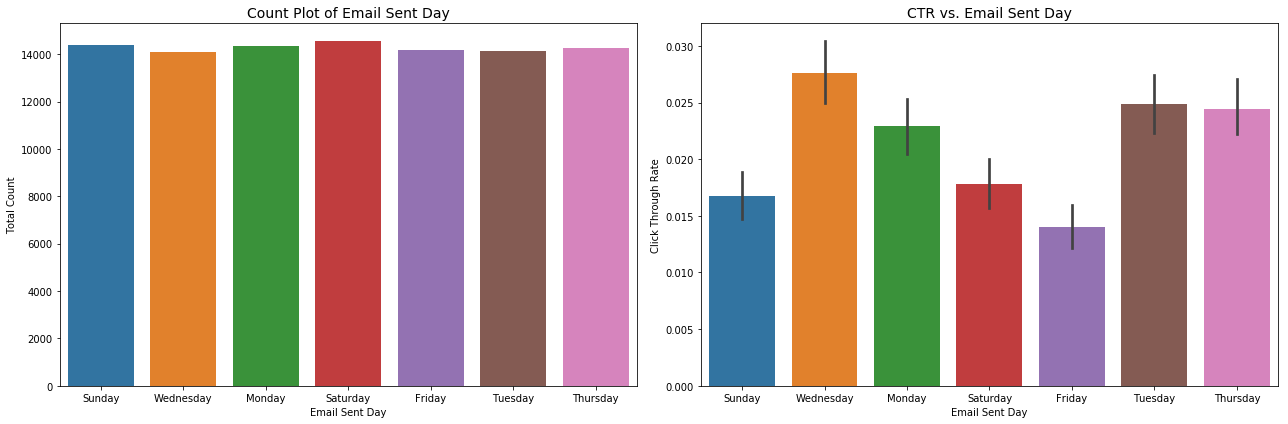

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'weekday', data = data, ax = ax[0])
ax[0].set_title('Count Plot of Email Sent Day', fontsize = 14)
ax[0].set_xlabel('Email Sent Day', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'weekday', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. Email Sent Day', fontsize = 14)
ax[1].set_xlabel('Email Sent Day', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

### User Country

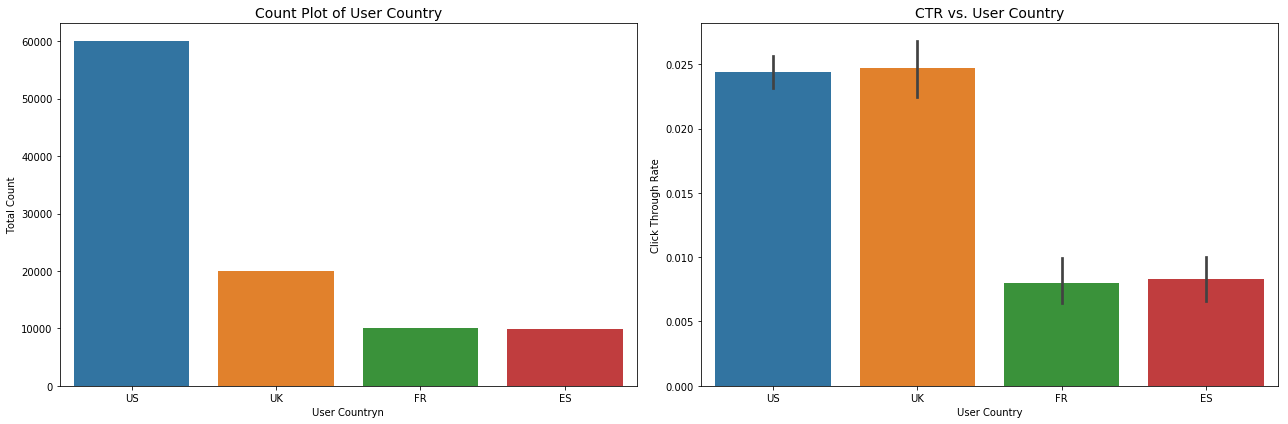

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'user_country', data = data, ax = ax[0])
ax[0].set_title('Count Plot of User Country', fontsize = 14)
ax[0].set_xlabel('User Countryn', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'user_country', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. User Country', fontsize = 14)
ax[1].set_xlabel('User Country', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

### User Past Purchase

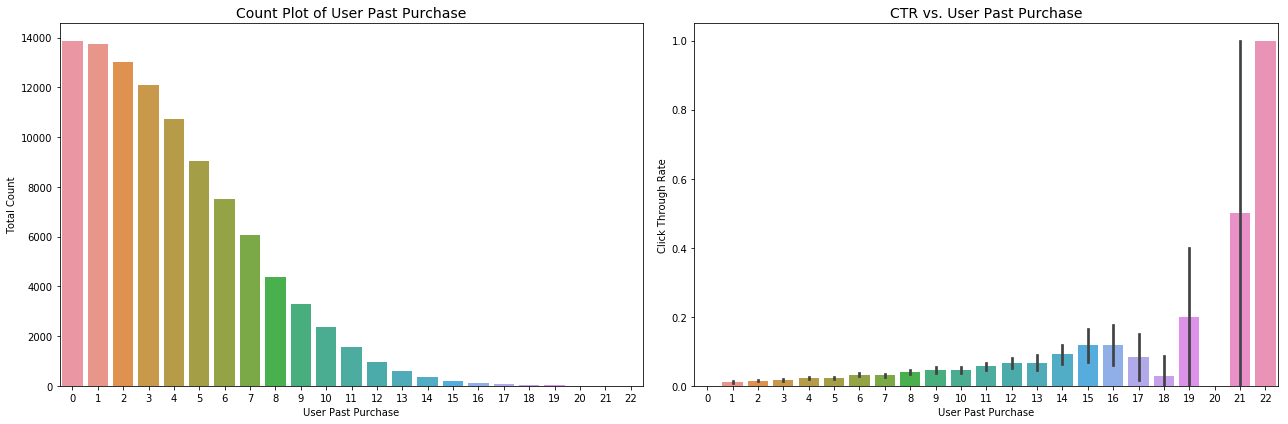

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18,6))
sns.countplot(x = 'user_past_purchases', data = data, ax = ax[0])
ax[0].set_title('Count Plot of User Past Purchase', fontsize = 14)
ax[0].set_xlabel('User Past Purchase', fontsize = 10)
ax[0].set_ylabel('Total Count', fontsize = 10)

sns.barplot(x = 'user_past_purchases', y = 'clicked', data = data, ax = ax[1])
ax[1].set_title('CTR vs. User Past Purchase', fontsize = 14)
ax[1].set_xlabel('User Past Purchase', fontsize = 10)
ax[1].set_ylabel('Click Through Rate', fontsize = 10)
plt.tight_layout()
plt.show()

## Build Model: Random Forest Classification

In [23]:
#Encode Categorical Data
data.dtypes

email_id                int64
email_text             object
email_version          object
hour                    int64
weekday                object
user_country           object
user_past_purchases     int64
opened                  int32
clicked                 int32
dtype: object

In [24]:
lb = LabelEncoder()
data['email_text_lb'] = lb.fit_transform(data['email_text'])
data[['email_text_lb', 'email_text']].head()


,email_text_lb,email_text
0,1,short_email
1,0,long_email
2,0,long_email
3,1,short_email
4,0,long_email


In [25]:
data['email_version_lb'] = lb.fit_transform(data['email_version'])
data[['email_version_lb', 'email_version']].head()

,email_version_lb,email_version
0,1,personalized
1,1,personalized
2,1,personalized
3,0,generic
4,0,generic


In [26]:
weekday = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
intmap = dict([(weekday, i) for i, weekday in enumerate(set(weekday))]) 
#make the new array hold corresponding integers instead of strings:
data['weekday_lb'] = [intmap[weekday] for weekday in data['weekday']]
data[['weekday_lb', 'weekday']].head()

,weekday_lb,weekday
0,0,Sunday
1,0,Sunday
2,2,Wednesday
3,1,Monday
4,1,Monday


In [27]:
data['user_country_lb'] = lb.fit_transform(data['user_country'])
data[['user_country_lb', 'user_country']].head()

,user_country_lb,user_country
0,3,US
1,2,UK
2,3,US
3,2,UK
4,3,US


In [28]:
lb_data = data[['email_text_lb', 'email_version_lb', 'hour', 'weekday_lb', 'user_country_lb','user_past_purchases', 'clicked']]
lb_data.head()

,email_text_lb,email_version_lb,hour,weekday_lb,user_country_lb,user_past_purchases,clicked
0,1,1,2,0,3,5,0
1,0,1,12,0,2,2,1
2,0,1,11,2,3,2,0
3,1,0,6,1,2,1,0
4,0,0,14,1,3,6,0


In [29]:
#Split training & test dataset(75%)
y = lb_data['clicked']
X_train, X_test, y_train, y_test = train_test_split(lb_data.iloc[:,:-1], y, random_state = 0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(75000, 6) (75000,)
(25000, 6) (25000,)


In [30]:
X_train.head()

,email_text_lb,email_version_lb,hour,weekday_lb,user_country_lb,user_past_purchases
2606,1,0,4,4,2,8
57228,1,0,6,0,0,8
8382,1,0,8,3,1,4
60281,0,0,7,3,3,3
48432,1,0,11,0,0,7


In [40]:
rf = RandomForestRegressor(n_estimators = 40, oob_score = True, random_state = 22, 
                            max_depth = 7, max_features = 'auto')
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=True, random_state=22, verbose=0, warm_start=False)

In [32]:
y_pred = rf.predict(X_train)
y_test_pre = rf.predict(X_test)
print ('AUC Score(Train):')
print(roc_auc_score(y_train, y_pred))
print('AUC Score(Test):')
print(roc_auc_score(y_test, y_test_pre))

AUC Score(Train):
0.7608268915102921
AUC Score(Test):
0.7326950212428002


In [33]:
#Adjust Model Params for better fit 
#n-estimator
pa_test1 = {'n_estimators': range(10, 41, 5)}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(oob_score = True, random_state = 42, 
                            max_depth = 13, max_features = 'auto'),
                        param_grid = pa_test1, scoring =  'roc_auc', cv = 5)
gsearch1.fit(X_train, y_train)

C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\danyu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OO

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': range(10, 41, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
res_df = pd.DataFrame(gsearch1.cv_results_)[['mean_train_score','std_train_score', 'params']]
print ('Train Param of n_estimators:')
res_df, gsearch1.best_params_, gsearch1.best_score_

Train Param of n_estimators:


(   mean_train_score  std_train_score                params
 0          0.935459         0.003158  {'n_estimators': 10}
 1          0.939971         0.002483  {'n_estimators': 15}
 2          0.943389         0.002464  {'n_estimators': 20}
 3          0.944742         0.002586  {'n_estimators': 25}
 4          0.945974         0.001916  {'n_estimators': 30}
 5          0.947222         0.001811  {'n_estimators': 35}
 6          0.947584         0.001853  {'n_estimators': 40},
 {'n_estimators': 40},
 0.6918494108698224)

In [35]:
#max_depth & random_state
pa_test2 = {'max_depth': range(4,17,3), 'random_state': range(22,63,10)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators = 35, oob_score = True, max_features = 'auto'),
                        param_grid = pa_test2, scoring = 'roc_auc', cv = 5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(4, 17, 3), 'random_state': range(22, 63, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [36]:
res_df2 = pd.DataFrame(gsearch2.cv_results_)[['mean_train_score', 'std_train_score', 'params']]
print ('Train Param of max_depth & random_state:')
res_df2, gsearch2.best_params_, gsearch2.best_score_

Train Param of max_depth & random_state:


(    mean_train_score  std_train_score                                 params
 0           0.739979         0.001842   {'max_depth': 4, 'random_state': 22}
 1           0.740570         0.001822   {'max_depth': 4, 'random_state': 32}
 2           0.741105         0.002024   {'max_depth': 4, 'random_state': 42}
 3           0.740695         0.002345   {'max_depth': 4, 'random_state': 52}
 4           0.740007         0.002092   {'max_depth': 4, 'random_state': 62}
 5           0.783079         0.003542   {'max_depth': 7, 'random_state': 22}
 6           0.782772         0.003318   {'max_depth': 7, 'random_state': 32}
 7           0.783244         0.002999   {'max_depth': 7, 'random_state': 42}
 8           0.783561         0.003038   {'max_depth': 7, 'random_state': 52}
 9           0.781582         0.002972   {'max_depth': 7, 'random_state': 62}
 10          0.867421         0.002311  {'max_depth': 10, 'random_state': 22}
 11          0.866824         0.002814  {'max_depth': 10, 'rando

In [41]:
#feature importances
features = list(X_train.columns)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
ipt = sorted(zip(features, importances), key = lambda x: x[1], reverse = True)
print('feature importance ranking:')
for f, val in ipt:
    print('{0:10s} | {1:.5f}'.format(f,val))

feature importance ranking:
user_past_purchases | 0.46876
hour       | 0.17228
user_country_lb | 0.11949
weekday_lb | 0.11001
email_version_lb | 0.07991
email_text_lb | 0.04955


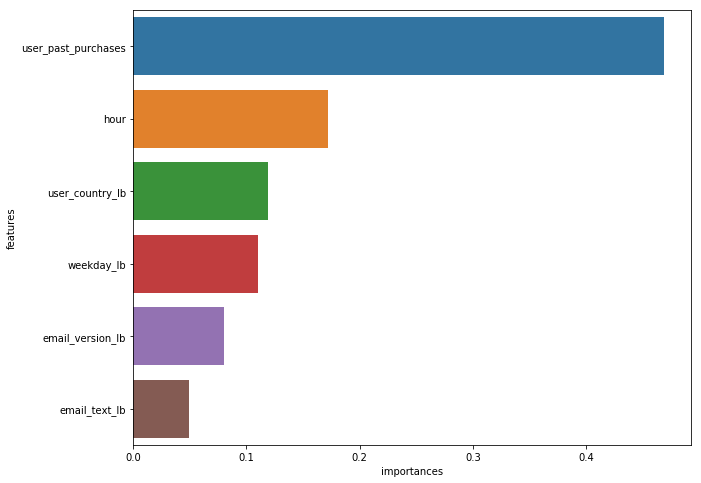

In [42]:
#feature importance plot
plt_ipt = pd.DataFrame(data = ipt, columns = ['features', 'importances'])
fig, ax = plt.subplots(figsize = (10, 8))
sns.barplot(x = 'importances', y = 'features', data = plt_ipt)
plt.show()

In [43]:
#prediction
train_pre = rf.predict(X_train)
test_pre = rf.predict(X_test)

train_fpr, train_tpr, threshold = roc_curve(y_train, train_pre)
test_fpr, test_tpr, threshold = roc_curve(y_test, test_pre)

train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)
print('train auc:' + str(train_auc))
print('test auc:'+ str(test_auc))

train auc:0.776
test auc:0.731


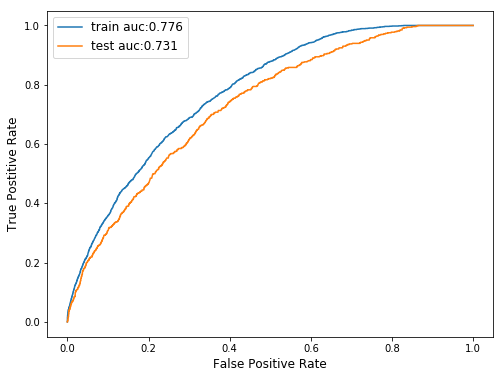

In [45]:
# plt
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(train_fpr, train_tpr, label = 'train auc:' + str(train_auc))
ax.plot(test_fpr, test_tpr, label = 'test auc:' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize = 12)
ax.set_ylabel('True Postitive Rate', fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

# Q3: CTR(#clicks/#recieved email)

To improve CTR, which is defined as number of clicks devided by numbers of recieved emails, we can improve it by increasing the number of clicks, which indicates that we can select users with high probability of click to send emails.

To test this, we can conduct A/B test to see if the built model can actually help to improve the click-through-rate

Process: 
1. Figuring out our goal, to improve CTR, we can choose user as our evaluation metric. Choose two random users as our control and experiment group.
    * For control group, everything remain same as before
    * For experiment group, use the built model to predict whether the user will click the link or not. Only send emails to those users whose predictive result is positive
    * Perform a one-tail unpaired t-test to test whether experiment group's population proportion is higher than control group's population proportion
    
    Null-Hypothesis(H0): Experiment group has higher population proportion than control group
    
    Alternative Hypothesis(H1): the population proportion in experiment group is no more high than that in control group
    

# Q4: Pattern on Customer Segmentation

In [59]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
clf = GradientBoostingRegressor(verbose=10)
clf.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0207            4.74s
         2           0.0206            3.96s
         3           0.0206            3.68s
         4           0.0206            3.54s
         5           0.0205            3.26s
         6           0.0205            3.03s
         7           0.0205            3.09s
         8           0.0205            2.96s
         9           0.0205            2.85s
        10           0.0205            2.74s
        11           0.0204            2.61s
        12           0.0204            2.57s
        13           0.0204            2.47s
        14           0.0204            2.41s
        15           0.0204            2.35s
        16           0.0204            2.29s
        17           0.0204            2.26s
        18           0.0204            2.22s
        19           0.0204            2.17s
        20           0.0204            2.13s
        21           0.0204            2.08s
        2

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=10, warm_start=False)

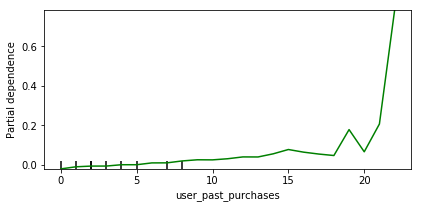

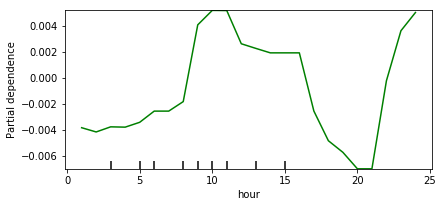

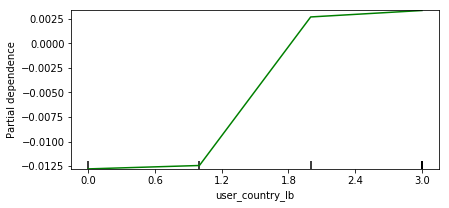

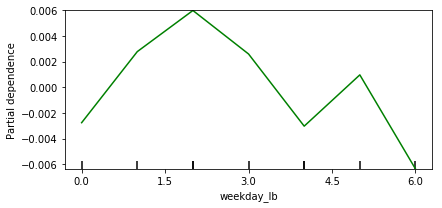

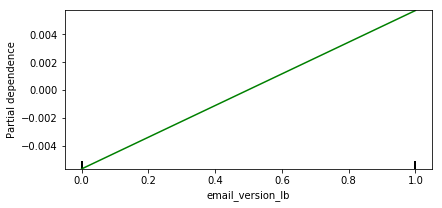

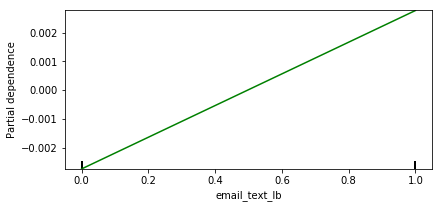

In [119]:
names = X_train.columns
for jj in range(0,6):
    features = indices[jj:(jj+1)]
    fig, axx = plot_partial_dependence(clf, X_train, features, feature_names=names, n_jobs=3, grid_resolution=30)
    #plt.subplots_adjust(left=0.2, top=0.9)